<a href="https://colab.research.google.com/github/grjadhav409/MCF7-inhibitors-prediction-using-ML/blob/main/5_9_pre_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Handling
import pandas as pd
import numpy as np
#from chembl_webresource_client.new_client import new_client
from scipy import stats
import os
import glob
import datetime as dt

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm 
import seaborn as sns
from IPython.display import Image
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Lipinski Descriptors rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# Splitting data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Data preprocessing
from sklearn.feature_selection import VarianceThreshold

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

# Assesing model performance
from sklearn import metrics
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_val_score

# Tunning
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Library to render the pyplots on github

import plotly.io as pio


--2022-04-14 10:24:29--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M  16.5MB/s    in 5.8s    

2022-04-14 10:24:35 (14.1 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37

# 1. Downloading Bioactivity Data from ChEMBL

In [ ]:
# ! pip install chembl_webresource_client

**1.2 Target search for prostate cancer**

In [ ]:
"""
# Target search for coronavirus
target = new_client.target
target_query = target.search('prostate cancer')
#target_query = target.search('aromatase')
targets = pd.DataFrame.from_dict(target_query)
targets
"""

"\n# Target search for coronavirus\ntarget = new_client.target\ntarget_query = target.search('prostate cancer')\n#target_query = target.search('aromatase')\ntargets = pd.DataFrame.from_dict(target_query)\ntargets\n"

In [ ]:
#Image(filename='figures/PSA.png', width=250, height=250) 

In [ ]:
#targets = targets.loc[(targets["organism"] == "Homo sapiens")&((targets["target_type"] == ("SINGLE PROTEIN"))|(targets["target_type"] == ("PROTEIN COMPLEX")))]	

In [ ]:
#selected_targets = targets.target_chembl_id[0:]
#selected_targets 
# Target ID for this protein is 'CHEMBL2099' (Unique Identificator)

In [ ]:
"""
df_dict = {} # Use a dict to save all df 

for target in selected_targets:
    activity = new_client.activity
    res = activity.filter(target_chembl_id=target).filter(standard_type="IC50")
    df = pd.DataFrame.from_dict(res)
    df_dict[target] = df
"""

'\ndf_dict = {} # Use a dict to save all df \n\nfor target in selected_targets:\n    activity = new_client.activity\n    res = activity.filter(target_chembl_id=target).filter(standard_type="IC50")\n    df = pd.DataFrame.from_dict(res)\n    df_dict[target] = df\n'

In [ ]:
#dfs = pd.concat(df_dict, axis=0)

In [ ]:
#dfs = dfs.reset_index()

In [ ]:
#dfs.shape

In [ ]:
#dfs.standard_type.unique()

In [ ]:
# So the list of possible cancer prostate targets are:
#list(dfs["target_pref_name"].unique())

In [ ]:
#dfs.to_csv('data/bioactivity_data.csv', index=False)

# 2. Data Cleaning and Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/drug discovery/MCF7/data/MCF7_data.csv",sep=';')

In [ ]:
df

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL1672983,NaN,0,549.55,2,4.18,2,COc1ccc(Cn2c3nc(-c4ccc([N+](=O)[O-])cc4)nc4c(n...,IC50,'=',...,MCF7,Homo sapiens,CELL-LINE,CHEMBL1671849,1,Scientific Literature,ACS Med. Chem. Lett.,2011.0,CHEMBL3308403,NaN
1,CHEMBL1672986,NaN,0,416.42,0,2.73,12,COc1ccc(Cn2cnc3c4nc(=O)n(Cc5ccc(F)cc5)c-4ncnc3...,IC50,'=',...,MCF7,Homo sapiens,CELL-LINE,CHEMBL1671849,1,Scientific Literature,ACS Med. Chem. Lett.,2011.0,CHEMBL3308403,NaN
2,CHEMBL2385634,NaN,0,482.66,1,6.45,"9, Fokihodgin I",C=CC(=C)CC[C@@H]1[C@@]2(C)CCC[C@](C)(COC(=O)/C...,IC50,'=',...,MCF7,Homo sapiens,CELL-LINE,CHEMBL2384963,1,Scientific Literature,J. Nat. Prod.,2013.0,CHEMBL3308403,NaN
3,CHEMBL2402999,NaN,0,520.61,1,4.90,3f,COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)...,IC50,'=',...,MCF7,Homo sapiens,CELL-LINE,CHEMBL2401715,1,Scientific Literature,Eur. J. Med. Chem.,2013.0,CHEMBL3308403,NaN
4,CHEMBL109480,TANESPIMYCIN,3,585.7,1,2.54,"Tanespimycin, 17-AAG",C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,IC50,NaN,...,MCF7,Homo sapiens,CELL-LINE,CHEMBL2375340,1,Scientific Literature,J. Nat. Prod.,2013.0,CHEMBL3308403,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43946,CHEMBL53463,DOXORUBICIN,4,543.53,3,0.00,adriamycin,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,IC50,'=',...,MCF7,Homo sapiens,CELL-LINE,CHEMBL1135677,1,Scientific Literature,J. Med. Chem.,2002.0,CHEMBL3308403,NaN
43947,CHEMBL83,TAMOXIFEN,4,371.52,1,6.00,TAMOXIFEN,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,IC50,'=',...,MCF7,Homo sapiens,CELL-LINE,CHEMBL1137766,1,Scientific Literature,Bioorg. Med. Chem.,2009.0,CHEMBL3308403,NaN
43948,CHEMBL53463,DOXORUBICIN,4,543.53,3,0.00,DOXO,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,IC50,'=',...,MCF7,Homo sapiens,CELL-LINE,CHEMBL3044684,1,Scientific Literature,Med Chem Res,2011.0,CHEMBL3308403,NaN
43949,CHEMBL53463,DOXORUBICIN,4,543.53,3,0.00,Doxorubicin,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,IC50,'=',...,MCF7,Homo sapiens,CELL-LINE,CHEMBL1129621,1,Scientific Literature,J. Med. Chem.,1996.0,CHEMBL3308403,NaN


In [ ]:
df.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

In [ ]:
df = df.dropna(subset=["Standard Value"])
df = df.reset_index(drop=True)

In [ ]:
def bioactivity_class_maker(item):
    if float(item) >= 10000:
        return "inactive"
    elif float(item) <= 1000:
        return "active"
    else:
        return "intermediate"

In [ ]:
df2 = df[["Target Name", "Molecule ChEMBL ID", "Smiles", "Standard Value"]]

In [ ]:
df2["bioactivity_class"] = df2["Standard Value"].apply(bioactivity_class_maker)

Saving dataframe to CSV file

In [ ]:
df2.to_csv('/content/sample_data/bioactivity_preprocessed_data.csv', index=False)

In [ ]:
# conda install -c rdkit rdkit -y

In [ ]:
df = pd.read_csv('/content/sample_data/bioactivity_preprocessed_data.csv')

In [ ]:
df = df.dropna(subset=["Smiles"]).reset_index(drop=True)

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

"""The function below takes the data from the canonical_smiles column that contains the molecular formula of each compound,
and returns a dataframe containing the lipinski parameters:
MW (molec. weight), 
Log P (solubility), 
NumHDonors and NumHAceptors (relative number of H-bond donors and aceptors, respectively)"""

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df["Smiles"])

In [ ]:
df = pd.concat([df, df_lipinski], axis=1)

In [ ]:
df

,Target Name,Molecule ChEMBL ID,Smiles,Standard Value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,MCF7,CHEMBL1672983,COc1ccc(Cn2c3nc(-c4ccc([N+](=O)[O-])cc4)nc4c(n...,5700.0,intermediate,549.547,4.1768,0.0,11.0
1,MCF7,CHEMBL1672986,COc1ccc(Cn2cnc3c4nc(=O)n(Cc5ccc(F)cc5)c-4ncnc3...,4000.0,intermediate,416.416,2.7321,0.0,8.0
2,MCF7,CHEMBL2385634,C=CC(=C)CC[C@@H]1[C@@]2(C)CCC[C@](C)(COC(=O)/C...,15370.0,inactive,482.661,6.4533,2.0,5.0
3,MCF7,CHEMBL2402999,COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)...,50130.0,inactive,520.607,4.8980,1.0,8.0
4,MCF7,CHEMBL1684472,CC[C@@H](C)C[C@@H](C)/C=C/CC[C@@H](O)[C@H](Cc1...,6200.0,intermediate,333.516,4.2923,3.0,3.0
...,...,...,...,...,...,...,...,...,...
42398,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,40.0,active,543.525,0.0013,6.0,12.0
42399,MCF7,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,10000.0,inactive,371.524,5.9961,0.0,2.0
42400,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,211.0,active,543.525,0.0013,6.0,12.0
42401,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,250.0,active,543.525,0.0013,6.0,12.0


In [ ]:
df["Smiles"] = df["Smiles"].str.replace("@", "O")

In [ ]:
def capping_large_values(item):
    if item > 100000000:
        return 100000000
    else:
        return item

In [ ]:
df["Standard Value"] = df["Standard Value"].apply(capping_large_values)

In [ ]:
len(df.loc[df["Standard Value"] == 100000000]) # no values needed to be capped

17

In [ ]:
def neg_log_transformation(item):
    item = item*(10**-9) # 1
    return -np.log10(item) # 2

In [ ]:
df["standard_value_transformed"] = df["Standard Value"].apply(neg_log_transformation)

In [ ]:
df[df["standard_value_transformed"]<0] # indeed we do not get negative values 

,Target Name,Molecule ChEMBL ID,Smiles,Standard Value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed


Lets check the data distribution of the IC50 values before and after the transformation

In [ ]:
import numpy as np

df[np.isfinite(df['Standard Value'])]
df[np.isfinite(df['standard_value_transformed'])]

,Target Name,Molecule ChEMBL ID,Smiles,Standard Value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed
0,MCF7,CHEMBL1672983,COc1ccc(Cn2c3nc(-c4ccc([N+](=O)[O-])cc4)nc4c(n...,5700.0,intermediate,549.547,4.1768,0.0,11.0,5.244125
1,MCF7,CHEMBL1672986,COc1ccc(Cn2cnc3c4nc(=O)n(Cc5ccc(F)cc5)c-4ncnc3...,4000.0,intermediate,416.416,2.7321,0.0,8.0,5.397940
2,MCF7,CHEMBL2385634,C=CC(=C)CC[COOH]1[COO]2(C)CCC[CO](C)(COC(=O)/C...,15370.0,inactive,482.661,6.4533,2.0,5.0,4.813326
3,MCF7,CHEMBL2402999,COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)...,50130.0,inactive,520.607,4.8980,1.0,8.0,4.299902
4,MCF7,CHEMBL1684472,CC[COOH](C)C[COOH](C)/C=C/CC[COOH](O)[COH](Cc1...,6200.0,intermediate,333.516,4.2923,3.0,3.0,5.207608
...,...,...,...,...,...,...,...,...,...,...
42398,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,40.0,active,543.525,0.0013,6.0,12.0,7.397940
42399,MCF7,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,10000.0,inactive,371.524,5.9961,0.0,2.0,5.000000
42400,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,211.0,active,543.525,0.0013,6.0,12.0,6.675718
42401,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,250.0,active,543.525,0.0013,6.0,12.0,6.602060


we can now drop the ``standard_value`` column

In [ ]:
df = df.drop("Standard Value", axis=1)

In [ ]:
df_EDA = df[~(df["bioactivity_class"] == "intermediate")]

In [ ]:
df_EDA = df_EDA.reset_index(drop=True)

In [ ]:
df_EDA

,Target Name,Molecule ChEMBL ID,Smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed
0,MCF7,CHEMBL2385634,C=CC(=C)CC[COOH]1[COO]2(C)CCC[CO](C)(COC(=O)/C...,inactive,482.661,6.4533,2.0,5.0,4.813326
1,MCF7,CHEMBL2402999,COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)...,inactive,520.607,4.8980,1.0,8.0,4.299902
2,MCF7,CHEMBL2260820,Cc1c(CCCl)c(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,active,338.625,4.7557,0.0,3.0,8.149354
3,MCF7,CHEMBL2260834,Cc1cc(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,active,276.126,3.9744,0.0,3.0,8.064997
4,MCF7,CHEMBL1652169,O=[N+]([O-])c1ccc(S(=O)(=O)N2C[COH](n3cnc4c(Cl...,active,521.342,3.9656,0.0,9.0,6.721246
...,...,...,...,...,...,...,...,...,...
31545,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,active,543.525,0.0013,6.0,12.0,7.397940
31546,MCF7,CHEMBL83,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,inactive,371.524,5.9961,0.0,2.0,5.000000
31547,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,active,543.525,0.0013,6.0,12.0,6.675718
31548,MCF7,CHEMBL53463,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,active,543.525,0.0013,6.0,12.0,6.602060


Now I will safe the df with all the data. We will come back to it during the modeling part

In [ ]:
df_EDA.to_csv('/content/sample_data/lipinski_data.csv', index=False)

In [ ]:
df_EDA = pd.read_csv("/content/sample_data/lipinski_data.csv")

In [ ]:
df_EDA.head()

,Target Name,Molecule ChEMBL ID,Smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed
0,MCF7,CHEMBL2385634,C=CC(=C)CC[COOH]1[COO]2(C)CCC[CO](C)(COC(=O)/C...,inactive,482.661,6.4533,2.0,5.0,4.813326
1,MCF7,CHEMBL2402999,COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)...,inactive,520.607,4.8980,1.0,8.0,4.299902
2,MCF7,CHEMBL2260820,Cc1c(CCCl)c(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,active,338.625,4.7557,0.0,3.0,8.149354
3,MCF7,CHEMBL2260834,Cc1cc(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,active,276.126,3.9744,0.0,3.0,8.064997
4,MCF7,CHEMBL1652169,O=[N+]([O-])c1ccc(S(=O)(=O)N2C[COH](n3cnc4c(Cl...,active,521.342,3.9656,0.0,9.0,6.721246


## 3. Exploratory Data Analysis:  
**Chemical Space Analysis using the Lipinski descriptors**

**3.1. Lets plot the frequency distribution of the two bioactivity classes**

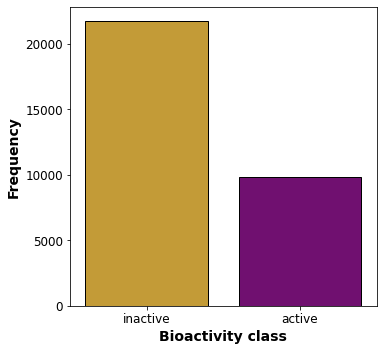

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_EDA, palette = ["goldenrod", "purple"], edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('figures/plot_bioactivity_class.png', dpi=300, bbox_inches="tight")
plt.show()

# 4.1 data preparation


## **Install padelpy**

In [ ]:
! pip install padelpy

     |████████████████████████████████| 20.9 MB 1.4 MB/s 


## **Prepare fingerprint XML**

### **Download fingerprint XML files**

In [ ]:
! wget https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
! unzip fingerprints_xml.zip

--2022-04-14 10:31:32--  https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip [following]
--2022-04-14 10:31:32--  https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10871 (11K) [application/zip]
Saving to: ‘fingerprints_xml.zip’

fingerprints_xml.zi 100%[===================>]  10.62K  --.-KB/s    in 0s      

2022-04-14 10:31:33 (50.2 MB/s) - ‘fingerprints_xml.zip’ saved [10871/10871]

Archive:  fingerprints_xm

### **List and sort fingerprint XML files**

In [ ]:
import glob
xml_files = glob.glob("*.xml")
xml_files.sort()
xml_files

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [ ]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

### **Create a dictionary**

In [ ]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'Substructure': 'SubstructureFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml'}

In [ ]:
fp['AtomPairs2D']

'AtomPairs2DFingerprinter.xml'

## **Prepare data subset as input to PaDEL**

In [ ]:
df2 = pd.concat( [df_EDA['Smiles'],df_EDA['Molecule ChEMBL ID']], axis=1 )
df2.to_csv('molecule.smi', sep='\t', index=False, header=False)
df2

,Smiles,Molecule ChEMBL ID
0,C=CC(=C)CC[COOH]1[COO]2(C)CCC[CO](C)(COC(=O)/C...,CHEMBL2385634
1,COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)...,CHEMBL2402999
2,Cc1c(CCCl)c(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,CHEMBL2260820
3,Cc1cc(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,CHEMBL2260834
4,O=[N+]([O-])c1ccc(S(=O)(=O)N2C[COH](n3cnc4c(Cl...,CHEMBL1652169
...,...,...
31545,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,CHEMBL53463
31546,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,CHEMBL83
31547,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,CHEMBL53463
31548,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,CHEMBL53463


## **Calculate descriptors**

There are 12 fingerprint types in PaDEL. To calculate all 12, make sure to make adjustments to the ***descriptortypes*** input argument to any of the ones in the ***fp*** dictionary variable as shown above, e.g. *SubstructureFingerprintCount.xml*

In [ ]:
fp

{'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'Substructure': 'SubstructureFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml'}

In [ ]:
fp['PubChem']

'PubchemFingerprinter.xml'

In [ ]:
from padelpy import padeldescriptor

fingerprint = 'Substructure'

fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

## **Display calculated fingerprints**

In [ ]:
descriptors = pd.read_csv(fingerprint_output_file)
descriptors

,Name,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,...,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307


## **Preparing the X and Y Data Matrices**

### **X data matrix**

In [ ]:
df3_X = pd.read_csv('descriptors_output.csv')

FileNotFoundError: ignored

In [ ]:
df3_X

In [ ]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

## **Y variable**

### **Convert IC50 to pIC50**

In [ ]:
df3_Y = df['pIC50']
df3_Y

## **Combining X and Y variable**

In [ ]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

# 4.2 

## **Download PaDEL-Descriptor**

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2022-04-14 10:35:36--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2022-04-14 10:35:36--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip.1’

padel.zip.1         100%[===================>]  24.57M   136MB/s    in 0.2s    

2022-04-14 10:35:37 (136 MB/s) - ‘padel.zip.1’ saved [25768637/25768637]

--2022-04-14 10:35:37--  https://gi

In [ ]:
! unzip padel.zip

Archive:  padel.zip
replace __MACOSX/._PaDEL-Descriptor? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config 

## **Load bioactivity data**

In [ ]:
selection = ['Smiles','Molecule ChEMBL ID']
df3_selection = df_EDA[selection]

In [ ]:
df3_selection

,canonical_smiles,molecule_chembl_id
0,C=CC(=C)CC[COOH]1[COO]2(C)CCC[CO](C)(COC(=O)/C...,CHEMBL2385634
1,COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)...,CHEMBL2402999
2,Cc1c(CCCl)c(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,CHEMBL2260820
3,Cc1cc(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,CHEMBL2260834
4,O=[N+]([O-])c1ccc(S(=O)(=O)N2C[COH](n3cnc4c(Cl...,CHEMBL1652169
...,...,...
31545,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,CHEMBL53463
31546,CC/C(=C(\c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,CHEMBL83
31547,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,CHEMBL53463
31548,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[COO](O)...,CHEMBL53463


In [ ]:
df4=df3_selection.rename(columns = {'Smiles':'canonical_smiles', 'Molecule ChEMBL ID':'molecule_chembl_id'})

In [ ]:
df4 =pd.DataFrame(data= df4)

In [ ]:
df4.head()

,canonical_smiles,molecule_chembl_id
0,C=CC(=C)CC[COOH]1[COO]2(C)CCC[CO](C)(COC(=O)/C...,CHEMBL2385634
1,COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)...,CHEMBL2402999
2,Cc1c(CCCl)c(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,CHEMBL2260820
3,Cc1cc(Cl)n2c(nc3ccc(Cl)cc32)c1C#N,CHEMBL2260834
4,O=[N+]([O-])c1ccc(S(=O)(=O)N2C[COH](n3cnc4c(Cl...,CHEMBL1652169


In [ ]:
df4.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! cat molecule.smi | head -5

C=CC(=C)CC[COOH]1[COO]2(C)CCC[CO](C)(COC(=O)/C=C\c3ccc(O)c(OC)c3)[COOH]2CC[COO]1(C)O	CHEMBL2385634
COc1cc(-c2nc3sc4c(c3c(=O)n2C(Cc2ccccc2)C(=O)O)CCCC4)cc(OC)c1OC	CHEMBL2402999
Cc1c(CCCl)c(Cl)n2c(nc3ccc(Cl)cc32)c1C#N	CHEMBL2260820
Cc1cc(Cl)n2c(nc3ccc(Cl)cc32)c1C#N	CHEMBL2260834
O=[N+]([O-])c1ccc(S(=O)(=O)N2C[COH](n3cnc4c(Cl)nc(Cl)nc43)OCc3ccccc32)cc1	CHEMBL1652169


In [ ]:
! cat molecule.smi | wc -l

31550


## **Calculate fingerprint descriptors**


### **Calculate PaDEL descriptors**

In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Descriptor calculation completed in 0.963 secs . Average speed: ∞ s/mol.


In [ ]:
! ls -l

total 136080
-rwxr-xr-x 1 root root     4645 Mar 27  2018 AtomPairs2DFingerprintCount.xml
-rwxr-xr-x 1 root root     4645 Mar 27  2018 AtomPairs2DFingerprinter.xml
-rw-r--r-- 1 root root    11348 Apr 14 10:45 descriptors_output.csv
drwx------ 5 root root     4096 Apr 14 10:24 drive
-rwxr-xr-x 1 root root     4645 Mar 27  2018 EStateFingerprinter.xml
-rwxr-xr-x 1 root root     4645 Mar 27  2018 ExtendedFingerprinter.xml
-rwxr-xr-x 1 root root     4645 Mar 27  2018 Fingerprinter.xml
-rw-r--r-- 1 root root    10871 Apr 14 10:31 fingerprints_xml.zip
-rwxr-xr-x 1 root root     4645 Mar 27  2018 GraphOnlyFingerprinter.xml
-rwxr-xr-x 1 root root     4645 Mar 27  2018 KlekotaRothFingerprintCount.xml
-rwxr-xr-x 1 root root     4645 Mar 27  2018 KlekotaRothFingerprinter.xml
-rwxr-xr-x 1 root root     4645 Mar 27  2018 MACCSFingerprinter.xml
drwxr-xr-x 3 root root     4096 Apr 14 10:37 __MACOSX
-rwxr-xr-x 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh
-rw-r--r-- 1 root ro

## **Preparing the X and Y Data Matrices**

### **X data matrix**

In [ ]:
df3_X = pd.read_csv('descriptors_output.csv')

In [ ]:
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880


In [ ]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880


## **Y variable**

### **Convert IC50 to pIC50**

In [ ]:
df3_Y = df3['pIC50']
df3_Y

0      4.286006
1      4.517412
2      4.419417
3      4.285251
4      4.392009
         ...   
955    5.022734
956    4.000000
957    4.036968
958    4.204537
959    4.240332
Name: pIC50, Length: 960, dtype: float64

# 5. Model Building

**5.1 Data Split**

In [ ]:
df_model = pd.read_csv("data/df_model.csv")

In [ ]:
X = df_model.drop(["standard_value_transformed"], axis=1)
y = df_model["standard_value_transformed"].values

In [ ]:
X2 = X.iloc[:,-29:] # the dummy molec groups variables

In [ ]:
X = X.iloc[:,:-29] # les separate the Pubchem features to remove those with low variance

In [ ]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [ ]:
X.shape # 177 low variance Pubchem features left 

(3375, 178)

In [ ]:
X = pd.DataFrame(X)

In [ ]:
X = pd.concat([X,X2], axis=1)

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,PDZ-binding kinase,PHD finger protein 13,Prostate specific antigen,Prostatic acid phosphatase,Serine/threonine-protein kinase ICK,Serine/threonine-protein kinase TAO1,Serine/threonine-protein kinase TAO2,Serine/threonine-protein kinase WNK2,Testis-specific serine/threonine-protein kinase 6,tRNA-dihydrouridine(20) synthase [NAD(P)+]-like
0,0,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,1,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3371,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3372,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3373,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**5.2 Assessing Model Performance**

In [ ]:
# Metrics used neg_mean_squared_error using cross-validation

models = []

models.append(('Lasso', Lasso())) 
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR())) 
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor())) 
models.append(('ETR', ExtraTreesRegressor()))


results_model = []
names_model = []
run_time = []
for name, model in models:
    KF = KFold(n_splits=10, random_state=42)
    start = dt.datetime.now()
    cv_results = cross_val_score(model, X_train, y_train, cv=KF, scoring='neg_mean_squared_error')
    results_model.append(cv_results)
    names_model.append(name)
    end  = dt.datetime.now() 
    duration = (end-start).seconds
    run_time.append(duration)
    msg = "%s: %s (%s) Running time: %s sec" % (name, round(cv_results.mean(),2), round(cv_results.std(),3), duration)
    print(msg)

Lasso: -1.21 (0.08) Running time: 0 sec
EN: -1.21 (0.08) Running time: 0 sec
CART: -1.14 (0.094) Running time: 0 sec
KNN: -0.81 (0.062) Running time: 3 sec
SVR: -0.75 (0.064) Running time: 15 sec
RFR: -0.77 (0.075) Running time: 33 sec
GBR: -0.77 (0.063) Running time: 11 sec
ETR: -1.09 (0.11) Running time: 46 sec


In [ ]:
run_sec = []
for i in run_time:
    s = str(i)+"s"
    run_sec.append(s)

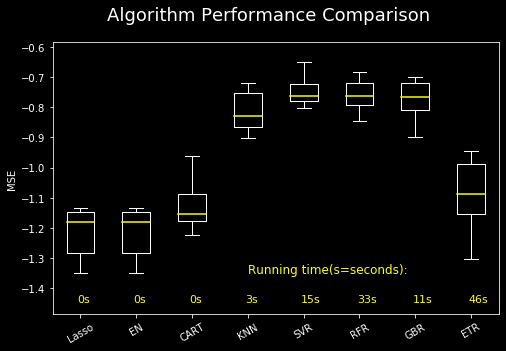

In [ ]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,5)
fig = plt.figure()
fig.suptitle('Algorithm Performance Comparison', fontsize=18)

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

plt.boxplot(results_model, 
            boxprops=boxprops,
            medianprops=medianprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            showfliers=True, 
            flierprops=flierprops)

x_values = list(range(1,len(run_sec)+1))
y_max = pd.DataFrame(results_model).max().max()
y_min = pd.DataFrame(results_model).min().min()

plt.text(s="Running time(s=seconds):", x = 4, y = y_min, color="yellow", fontsize=12) 
plt.ylim(y_min + 0.1*y_min, y_max - 0.1*y_max)
for i in range(len(x_values)):
    plt.text(s=run_sec[i], x = x_values[i]-0.05, y = y_min + 0.07*y_min, color="yellow", fontsize=11)  

ax = fig.add_subplot(111)
ax.set_xticklabels(names_model, rotation=30)
ax.set_ylabel("MSE")

plt.savefig("figures/algo_comparisson_drug.png", dpi=400, bbox_inches="tight")

plt.show()

The above analysis revealed **Support Vector Machine (SVM)** and **Random Forest Regressor (RFR)** as the most promissing models. Lets fine tune them using GridSearchCV.

**5.3: Fine Tunning and Model Evaluation**

In [ ]:
# GridSearchCV
kernel = ["rbf"] # ["linear", "poly", "rbf", "sigmoid"] 
C = [2, 3, 4] # higher values lower regularization
epsilon = [0.2, 0.3, 0.4] # lower values lower regularization
tol = [0.002]

param_grid = dict(kernel=kernel, C=C, epsilon=epsilon, tol=tol)

model = SVR()
KF = KFold(n_splits=5, random_state=42) 
grid = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s"
      % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best  -0.758105 using {'C': 2, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}

Best: -0.758105 using {'C': 2, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-0.758105 (0.048389) with: {'C': 2, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-0.759795 (0.049171) with: {'C': 2, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-0.763106 (0.051293) with: {'C': 2, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}
-0.765272 (0.047047) with: {'C': 3, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-0.764321 (0.046633) with: {'C': 3, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-0.767056 (0.048498) with: {'C': 3, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}
-0.773371 (0.046178) with: {'C': 4, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-0.771148 (0.045009) with: {'C': 4, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-0.771923 (0.049438) with: {'C': 4, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}


In [ ]:
score_test_SVReg = round(SVReg.score(X_test,y_test),3) 

In [ ]:
score_test_SVReg

0.429

In [ ]:
# After trying different combinations we reached the following model 
RFReg = RandomForestRegressor(n_estimators=45, max_depth=10, min_samples_leaf=4, min_samples_split=2) # 
RFReg.fit(X_train,y_train) # 50, 12, 1, 4

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=45, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
score_train_RFReg = round(RFReg.score(X_train,y_train),3) 

In [ ]:
score_train_RFReg

0.596

In [ ]:
score_test_RFReg = round(RFReg.score(X_test,y_test),3) 

In [ ]:
score_test_RFReg

0.478

In [ ]:
y_pred = RFReg.predict(X_test)
y_pred= y_pred.reshape(-1,1)

In [ ]:
metrics.mean_squared_error(y_test, y_pred)

0.6604058007600125

In [ ]:
metrics.mean_absolute_error(y_test, y_pred)

0.60454214326872

In [ ]:
(y_test.reshape(-1,1)).shape

(675, 1)

In [ ]:
y_pred.shape

(675, 1)

In [ ]:
df_scatter = pd.DataFrame(np.concatenate((y_test.reshape(-1,1), y_pred), axis=1), columns=["y_test_pIC50", "y_pred_pIC50"])

In [ ]:
df_scatter

,y_test_pIC50,y_pred_pIC50
0,5.371815,5.349730
1,6.769551,6.660771
2,5.283579,5.646393
3,5.301030,6.656953
4,5.306713,5.334748
...,...,...
670,5.399790,5.308601
671,8.229148,6.741740
672,5.568636,5.848181
673,5.370590,6.334623


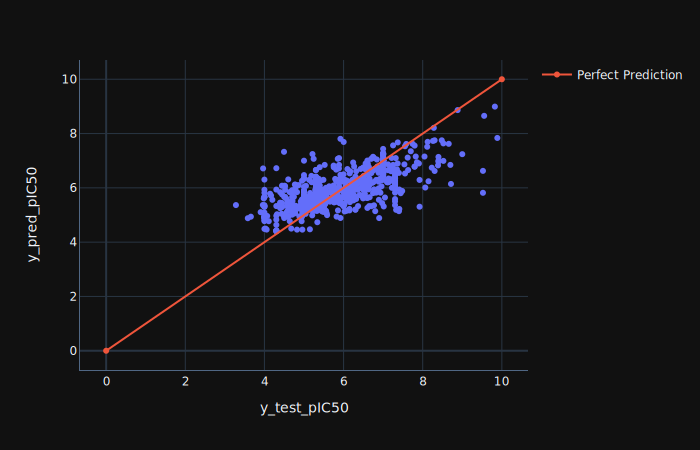

In [ ]:
fig = px.scatter(df_scatter,
                x="y_test_pIC50", 
                y="y_pred_pIC50",
                hover_name=df_scatter.index,
                hover_data=[df_scatter.index],
                template="plotly_dark", width=700, height=500)
fig.add_trace(go.Line(x=[0,10], y=[0,10], name="Perfect Prediction"))
fig.show()